In [99]:
import pickle
import numpy as np
from scipy.spatial import distance
from joblib import load
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from matplotlib import pyplot as plt
from gensim.models.doc2vec import Doc2Vec
from gensim.models import Word2Vec, TfidfModel
from gensim.corpora import Dictionary

# Load data

In [3]:
# validation set questions and corresponding FAQs
data_prefix='../../data/12-08-'
with open(data_prefix + 'val-test.pkl', "rb") as fp:
    test_dic = pickle.load(fp) 

In [45]:
# unlabelled data
# load data:
with open("../../code/embedding/models/doc_data/all_docs_sep.pkl", "rb") as fp:
    all_docs_sep = pickle.load(fp)

faq_ques = all_docs_sep['faq_ques']    
faq_ans = all_docs_sep['faq_ans']
ticket_ques = all_docs_sep['ticket_ques']
ticket_ans = all_docs_sep['ticket_ans']

In [7]:
# quick put together of validation set answers
labelled_data = pd.read_csv('../../data/validate.csv')
all_path = '../../data/12-04-ticket_dat.csv'
x_all = pd.read_csv(all_path)
x_val_ind = list(labelled_data.ticket_id)
x_val_ans = np.asarray(x_all.loc[x_all['ticket_id'].isin(x_val_ind)].sort_values("ticket_id")["answer"])

# TFiDF Question to FAQ similarity

In [10]:
TFiDF_ques = load('../../code/embedding/models/TF-IFD-ticket-ques.joblib')
# make matrix
FAQ_matrix_ques = TFiDF_ques.transform(faq_ans)
ticket_matrix_ques = TFiDF_ques.transform(ticket_ques)
# similarities
sim_matrix_ques = cosine_similarity(FAQ_matrix_ques, ticket_matrix_ques)
# Using Closest FAQ similarity as a measure 
strength_FAQ_ticket_ques = np.max(sim_matrix_ques, axis=0)

In [15]:
val_matrix_ques = TFiDF_ques.transform(test_dic["x_val"])
#
test_dic["y_val"][test_dic["y_val"]==199]=-1
val_pos_ques = val_matrix_ques[test_dic["y_val"]!=-1,:]
val_neg_ques = val_matrix_ques[test_dic["y_val"]==-1,:]
val_neg_ques.shape, val_pos_ques.shape
#
sFT_val_pos_ques = np.max(cosine_similarity(FAQ_matrix_ques, val_pos_ques), axis=0)
sFT_val_neg_ques = np.max(cosine_similarity(FAQ_matrix_ques, val_neg_ques), axis=0)

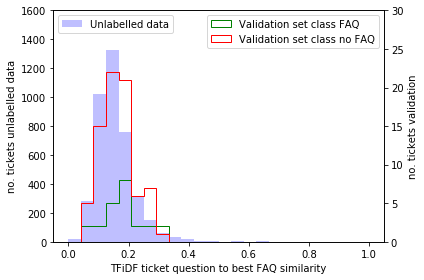

In [16]:
fig, ax1 = plt.subplots()
bins =  np.linspace(0, 1,25)
ax1.hist(strength_FAQ_ticket_ques, bins,alpha=.25, label="Unlabelled data", color="blue")
ax1.set_xlabel('TFiDF ticket question to best FAQ similarity')
ax1.set_ylabel('no. tickets unlabelled data')
plt.ylim(top=1600) 
ax2 = ax1.twinx()
ax2.hist(sFT_val_pos_ques, bins,alpha=1, label="Validation set class FAQ", color = "green", histtype ="step")
ax2.hist(sFT_val_neg_ques, bins,alpha=1, label="Validation set class no FAQ", color = "red", histtype ="step")
ax2.set_ylabel('no. tickets validation')
plt.ylim(top=30) 
fig.tight_layout()
ax1.legend(loc=2)
ax2.legend()
plt.show()

# TFiDF Question to FAQ similarity

In [75]:
TFiDF_ans = load('../../code/embedding/models/TF-IFD-ans.joblib')
FAQ_matrix_ans = TFiDF_ans.transform(faq_ans)
ticket_matrix_ans = TFiDF_ans.transform(ticket_ans)
sim_matrix_ans = cosine_similarity(FAQ_matrix_ans, ticket_matrix_ans)
strength_FAQ_ticket_max_ans = np.max(sim_matrix_ans, axis=0)

In [76]:
val_matrix_ans = TFiDF_ans.transform(x_val_ans)
val_pos_ans = val_matrix_ans[test_dic["y_val"]!=-1,:]
val_neg_ans = val_matrix_ans[test_dic["y_val"]==-1,:]
sFT_val_pos_ans = np.max(cosine_similarity(FAQ_matrix_ans, val_pos_ans), axis=0)
sFT_val_neg_ans = np.max(cosine_similarity(FAQ_matrix_ans, val_neg_ans), axis=0)

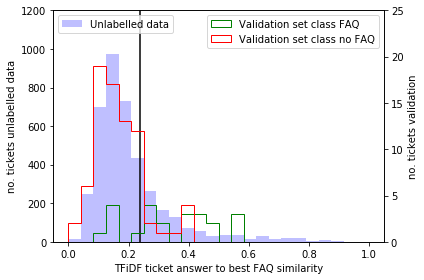

thresh= 0.23799952906832816


In [94]:
fig, ax1 = plt.subplots()
bins =  np.linspace(0, 1,25)
ax1.hist(strength_FAQ_ticket_max_ans, bins,alpha=.25, label="Unlabelled data", color="blue")
ax1.set_xlabel('TFiDF ticket answer to best FAQ similarity')
ax1.set_ylabel('no. tickets unlabelled data')
plt.ylim(top=1200) 
thresh = np.quantile(strength_FAQ_ticket_max_ans,0.75)
plt.axvline(x=thresh,color='k',ymax=1000)
ax2 = ax1.twinx()
ax2.hist(sFT_val_pos_ans, bins,alpha=1, label="Validation set class FAQ", color = "green", histtype ="step")
ax2.hist(sFT_val_neg_ans, bins,alpha=1, label="Validation set class no FAQ", color = "red", histtype ="step")
ax2.set_ylabel('no. tickets validation')
plt.ylim(top=25) 
fig.tight_layout()
ax1.legend(loc=2)
ax2.legend()
plt.show()
print("thresh=",thresh)

# doc2vec similarity

In [84]:
model_path = '../../code/embedding/models/doc2vec_ans.model'
model = Doc2Vec.load(model_path)

n_faq = len(faq_ans)
n_ticket = len(ticket_ans)
faq_em = np.array([model.docvecs[i] for i in range(n_faq)])
ticket_em = np.array([model.docvecs[i] for i in range(n_faq, n_faq + n_ticket)])

val_prepro = preprocess_docs_fn(x_val_ans)
# embed data
doc2vec_val = np.array([model.infer_vector(val_prepro[i]) for i in range(len(val_prepro))])

In [85]:
SFT, valyes, valno = do_stuff(faq_em, ticket_em, doc2vec_val)

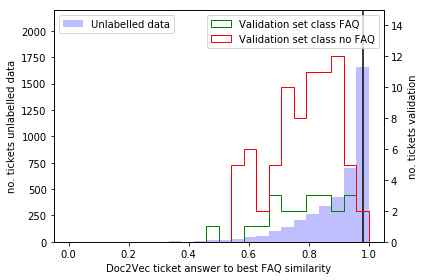

thresh= 0.9806503504514694


In [86]:
legend = 'Doc2Vec ticket answer to best FAQ similarity'
plot_stuff(SFT, valyes, valno, a = 2200, b = 15, l = legend)

# word2vec similarity

In [87]:
model_path = '../../code/embedding/models/word2vec_all.model'
model = Word2Vec.load(model_path)
# word2vec is trained on 
all_docs = faq_ques + faq_ans + ticket_ques + ticket_ans
all_docs_prepro = preprocess_docs_fn(all_docs)
#
ind_tix_ans_start = 2*len(faq_ans) + len(ticket_ques)
ind_tix_ans_end = 2*len(faq_ans) + 2*len(ticket_ques)

In [88]:
mean_ticket_ans = doc_emb_one_MR(ind_start=ind_tix_ans_start,
                                 ind_end=ind_tix_ans_end,
                                 all_docs_prepro=all_docs_prepro,
                                 model=model)

/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [89]:
ind_faq_ans_start = len(faq_ans)
ind_faq_ans_end = 2*len(faq_ans)
mean_faq_ans = doc_emb_one_MR(ind_start=ind_faq_ans_start,
                                 ind_end=ind_faq_ans_end,
                                 all_docs_prepro=all_docs_prepro,
                                 model=model)

/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [90]:
#val_prepro = preprocess_docs_fn(x_val_ans) # this was already done above
word2vec_val = doc_emb_new_one_MR(ind_start=0, 
                                  ind_end=len(x_val_ans),
                                  all_docs_prepro=val_prepro,
                                  model=model)

/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [91]:
# checking something happened :)
np.sum(word2vec_val>0)/(100*128), len(val_prepro)

(0.48046875, 100)

In [92]:
SFT, valyes, valno = do_stuff(mean_faq_ans, mean_ticket_ans, word2vec_val)

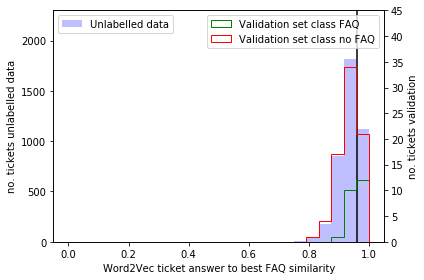

thresh= 0.9606682316423966


In [93]:
legend = 'Word2Vec ticket answer to best FAQ similarity'
plot_stuff(SFT, valyes, valno, a = 2300, b = 45, l = legend)

# word2vec + TFiDF

In [100]:
# TODO: start back here, understand how to predict for new points xxx
print('Loading Word2vec model')
model_path = '../../code/embedding/models/word2vec_all.model'
model_w2v = Word2Vec.load(model_path)

print('Loading Tfidf model')
model_path = '../../code/embedding/models/tfidf_all.model'
model_tfidf = TfidfModel.load(model_path)

dct = Dictionary(all_docs_prepro)
dct_val = Dictionary(val_prepro)
corpus = [dct.doc2bow(line) for line in all_docs_prepro]
corpus_val = [dct_val.doc2bow(line) for line in val_prepro]

Loading Word2vec model
Loading Tfidf model


In [106]:
ind_tix_ans_start = 2*len(faq_ans) + len(ticket_ques)
ind_tix_ans_end = 2*len(faq_ans) + 2*len(ticket_ques)
ind_faq_ans_start = len(faq_ans)
ind_faq_ans_end = 2*len(faq_ans)

mean_ticket_ans = all_avg(doc_prepro=all_docs_prepro,
                          ind_start=ind_tix_ans_start,
                          ind_end=ind_tix_ans_end,
                          corpus=corpus,
                          dct=dct,
                       model_w2v=model_w2v,
                       model_tfidf=model_tfidf)
mean_faq_ans = all_avg(doc_prepro=all_docs_prepro,
                          ind_start=ind_faq_ans_start,
                          ind_end=ind_faq_ans_end,
                          corpus=corpus,
                          dct=dct,
                       model_w2v=model_w2v,
                       model_tfidf=model_tfidf)

/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


In [120]:
last_m_val = all_avg(doc_prepro=val_prepro,
                     ind_start=0,
                     ind_end=len(val_prepro),
                     corpus=corpus_val,
                     dct=dct_val,
                     model_w2v=model_w2v,
                     model_tfidf=model_tfidf)

/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [121]:
np.sum(last_m_val>0)/(100*128), len(val_prepro)

(0.49984375, 100)

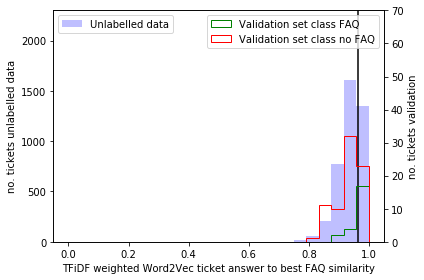

thresh= 0.9649842828699087


In [122]:
SFT, valyes, valno = do_stuff(mean_faq_ans, mean_ticket_ans, last_m_val)
legend = 'TFiDF weighted Word2Vec ticket answer to best FAQ similarity'
plot_stuff(SFT, valyes, valno, a = 2300, b = 70, l = legend)

# Utils

In [83]:
def do_stuff(FAQ_matrix_ans,ticket_matrix_ans, val_matrix_ans):
    sim_matrix_ans = cosine_similarity(FAQ_matrix_ans, ticket_matrix_ans)
    strength_FAQ_ticket_max_ans = np.max(sim_matrix_ans, axis=0)
    val_pos_ans = val_matrix_ans[test_dic["y_val"]!=-1,:]
    val_neg_ans = val_matrix_ans[test_dic["y_val"]==-1,:]
    sFT_val_pos_ans = np.max(cosine_similarity(FAQ_matrix_ans, val_pos_ans), axis=0)
    sFT_val_neg_ans = np.max(cosine_similarity(FAQ_matrix_ans, val_neg_ans), axis=0)
    return strength_FAQ_ticket_max_ans, sFT_val_pos_ans, sFT_val_neg_ans

def plot_stuff(strength_FAQ_ticket_max_ans,sFT_val_pos_ans,sFT_val_neg_ans, a=1200, b=25, l= "GIMME A NAME"):
    fig, ax1 = plt.subplots()
    bins =  np.linspace(0, 1,25)
    ax1.hist(strength_FAQ_ticket_max_ans, bins,alpha=.25, label="Unlabelled data", color="blue")
    ax1.set_xlabel(l)
    ax1.set_ylabel('no. tickets unlabelled data')
    thresh = np.quantile(strength_FAQ_ticket_max_ans,0.75)
    plt.axvline(x=thresh,color='k',ymax=a-100)
    plt.ylim(top=a) 
    ax2 = ax1.twinx()
    ax2.hist(sFT_val_pos_ans, bins,alpha=1, label="Validation set class FAQ", color = "green", histtype ="step")
    ax2.hist(sFT_val_neg_ans, bins,alpha=1, label="Validation set class no FAQ", color = "red", histtype ="step")
    ax2.set_ylabel('no. tickets validation')
    plt.ylim(top=b) 
    fig.tight_layout()
    ax1.legend(loc=2)
    ax2.legend()
    plt.show()
    print("thresh=",thresh)

In [27]:
from gensim.parsing.preprocessing import preprocess_string
import re
import string

from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import strip_multiple_whitespaces
from gensim.parsing.preprocessing import stem_text
from gensim.parsing.preprocessing import strip_numeric


def remove_ip(s):
    # Replace all ip adresses with '<ip>' tag
    ip_regexp = r"\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b"
    return re.sub(ip_regexp, '<ip>', s)


def remove_email(s):
    # Replace all email adresses with '<email>' tag
    email_regexp = r"([a-zA-Z0-9_\-\.]+)@([a-zA-Z0-9_\-\.]+)\.([a-zA-Z]{2,5})"
    return re.sub(email_regexp, '<email>', s)


def remove_mailto(s):
    # Replace all "<mailto:<email>>" with <email>. Email adresses should be replaced by remove_email first.
    return s.replace("<mailto:<email>>", "<email>")


def remove_url(s):
    # Replace all url's with '<url>' tag
    url_regexp = r"((http|ftp|https):\/\/)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)"
    s = re.sub(url_regexp, '<url>', s)
    # Sometimes url's are inside <> so we need to replace <<url>> with <url>
    return s.replace("<<url>>", "<url>")


def remove_punc(s, exceptions):
    # Remove all punctuation from string with exceptions in list exceptions
    remove = string.punctuation
    for exception in exceptions:
        remove = remove.replace(exception, "")
    # Create the pattern
    pattern = r"[{}]".format(remove)

    return re.sub(pattern, "", s)


def remove_custom_stopwords(s, stopwords):
    for stopword in stopwords:
        s = s.replace(stopword, "")
    return s


def lower_case(s):
    return s.lower()


def preprocess_sentence_fn(s):
    # Preprocess a single sentence to a list of tokens
    punc_exceptions = ['<', '>']
    custom_stopwords = ['dear', 'sincerely', 'thanks', 'yours', 'regards']

    filters = [lower_case,
               remove_ip,
               remove_email,
               remove_mailto,
               #remove_url,
               lambda x: remove_punc(x, punc_exceptions),
               remove_stopwords,
               lambda x: remove_custom_stopwords(x, custom_stopwords),
               strip_multiple_whitespaces,
               stem_text,
               strip_numeric]
    out = preprocess_string(s, filters=filters)

    return out


def preprocess_docs_fn(docs):
    # Apply preprocess_sentence_fn to a list of sentances (docs) to get a list of lists
    return [preprocess_sentence_fn(s) for s in docs]


In [59]:
# compute sentence embedding for word2vec
def doc_emb_one(name, id_dict, all_docs_prepro, model):
    mean_ans = np.empty((len(id_dict[name]), 128), dtype=float)
    for j in id_dict[name]:
        sentence = all_docs_prepro[j]
        words = np.empty((len(sentence), 128), dtype=float)
        for i in range(len(sentence)):
            words[i] = model[sentence[i]]
        mean_ans[j - id_dict[name][0]] = np.apply_along_axis(np.mean, 0, words)
    return mean_ans

# compute sentence embedding for word2vec
def doc_emb_one_MR(ind_start, ind_end, all_docs_prepro, model):
    length = ind_end - ind_start
    mean_ans = np.empty((length, 128), dtype=float)
    for j in range(ind_start, ind_end):
        sentence = all_docs_prepro[j]
        words = np.empty((len(sentence), 128), dtype=float)
        for i in range(len(sentence)):
            words[i] = model[sentence[i]]
        mean_ans[j - ind_start] = np.apply_along_axis(np.mean, 0, words)
    return mean_ans

# doc2vec equivalent 
# doc2vec_val = np.array([model.infer_vector(val_prepro[i]) for i in range(len(val_prepro))])
def doc_emb_new_one_MR(ind_start, ind_end, all_docs_prepro, model):
    length = ind_end - ind_start
    mean_ans = np.empty((length, 128), dtype=float)
    # extract vocabulary
    word_vectors = model.wv
    for j in range(ind_start, ind_end):
        sentence = all_docs_prepro[j]
        # let's go a little old school
        words = np.empty(128, dtype=float)
        #words = np.empty((len(sentence), 128), dtype=float)
        counter = 0
        for i in range(len(sentence)):
            if sentence[i] in word_vectors.vocab:
                words += model[sentence[i]]
                counter +=1
        mean_ans[j - ind_start] = words/counter
    return mean_ans


# compute sentence embedding for tfidf_w2v
def all_average(dat, corpus, dct, model_w2v, model_tfidf, id_dict, all_docs_prepro):
    if dat == 'faq_ans':
        ind = id_dict['faq_ans'][0]
        leng = len(id_dict['faq_ans'])
        dat = all_docs_prepro[ind:leng]
    elif dat == 'ticket_ans':
        ind = id_dict['ticket_ans'][0]
        leng = len(id_dict['ticket_ans'])
        dat = all_docs_prepro[ind:leng]
    else:
        ind = id_dict['ticket_ques'][0]
        leng = len(id_dict['ticket_ques'])
        dat = all_docs_prepro[ind:leng]
    mean_ans = np.empty((leng, 128), dtype=float)
    for i in range(leng):
        vector = np.asarray(model_tfidf[corpus[ind]], dtype=float)
        words = np.empty((len(vector), 128), dtype=float)
        for j in range(len(vector)):
            words[j] = model_w2v[dct[int(vector[j,0])]]
        mean_ans[i] = np.average(words, 0, weights=vector[:,1])
        ind += 1
    return mean_ans

In [119]:
def all_avg(doc_prepro=all_docs_prepro,
            ind_start=ind_tix_ans_start,
            ind_end=ind_tix_ans_end,
            corpus=corpus,
            dct=dct,
            model_w2v=model_w2v,
            model_tfidf=model_tfidf):
    # extract vocabulary
    word_vectors = model_w2v.wv
    dat = doc_prepro[ind_start:ind_end]
    length = ind_end - ind_start
    mean_ans = np.empty((length, 128), dtype=float)
    for i in range(length):
        vector = np.asarray(model_tfidf[corpus[ind_start]], dtype=float)
        words = np.empty((len(vector), 128), dtype=float)
        for j in range(len(vector)):
            if dct[int(vector[j,0])] in word_vectors.vocab:
                words[j] = model_w2v[dct[int(vector[j,0])]]
            else:
                words[j] = 0
        mean_ans[i] = np.average(words, 0, weights=vector[:,1])
        ind_start += 1
    return mean_ans